# Insurance Cost Prediction based on Patient's Health and Age

**Objective:** In this capstone project, the primary aim is to predict insurance cost based on information of the patients. This can help insurance companies and individuals to help predict and plan for insurance costs considering the various health factors.

1. [Data Exploration](#data)
2. [Data Transformation](#dt)
3. [Clustering](#clustering)
4. [Model Training](#train)
5. [Model Evaluation & Interpretation](#eval-interpret)
6. [Reference](#reference)

In [1]:
import pandas as pd
import random
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

# clustering
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture

# model building & evaluation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

#Handle Warnings
import warnings
warnings.filterwarnings("ignore")

# THE DATA:<a id="data"></a>

This dataset contains 1338 rows of insured data, where the Insurance charges are given against the following attributes of the insured: Age, Sex, BMI, Number of Children, Smoker and Region. The attributes are a mix of numeric and categorical variables.

In [2]:
df = pd.read_csv(r"./data/insurance.csv")
df.drop_duplicates(keep="first",inplace=True)
df.sample(5)

,age,sex,bmi,children,smoker,region,charges
428,21,female,16.815,1,no,northeast,3167.45585
1179,31,male,29.810,0,yes,southeast,19350.36890
800,42,female,26.180,1,no,southeast,7046.72220
856,48,female,33.110,0,yes,southeast,40974.16490
715,60,male,28.900,0,no,southwest,12146.97100


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
 6   charges   1337 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 83.6+ KB


&emsp;**Analysis:** There are no missing values, so we don't need to fill in the missing values, but there are number variables and categorical variables, so we need to encode them to run the regression.

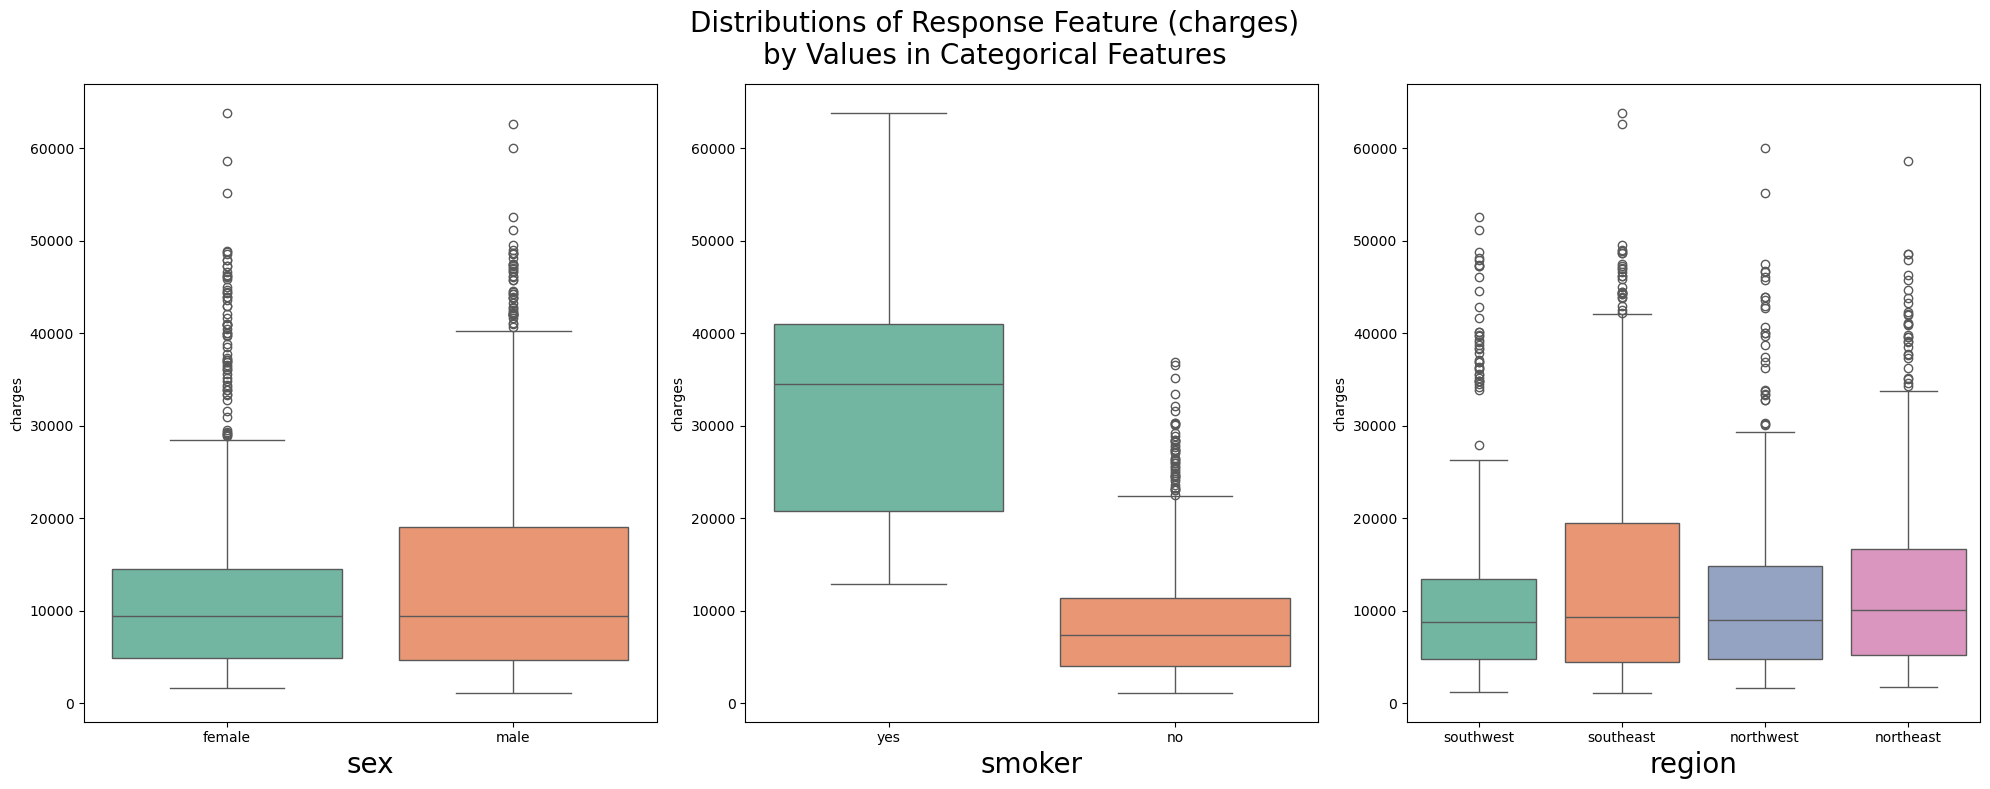

In [4]:
# Boxplots for categorical features
fig = plt.figure(figsize=(20,8))
for i, feature in enumerate(df.select_dtypes(include=object).columns):
    ax = fig.add_subplot(1, 3, i+1)
    sns.boxplot(df, x=feature, y='charges', hue=feature, palette=sns.color_palette('Set2', n_colors=len(df[feature].value_counts().index)), ax=ax)
    ax.set_xlabel(feature, fontsize=20)
fig.suptitle("Distributions of Response Feature (charges)\nby Values in Categorical Features", fontsize=20)
fig.tight_layout()
plt.show()

&emsp;**Analysis:** Simply looking at the distributions from the boxplots, there is a clear difference in the distributions of medical costs between smokers and non-smokers. Thus, **smoker** seems to be a promising feature for the training the model. Apart from this apparent difference, people who are males in **sex** seems to have higher medical costs in general.

# DATA TRANSFORMATION: <a id='dt'></a>
Transforming the whole data to numeric values. 

In [5]:
#ordinal encoding
enc_data = df.copy(deep=True)

from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()

enc.fit(enc_data["sex"])
enc_data["sex"] = enc.transform(enc_data["sex"])

enc.fit(enc_data["smoker"])
enc_data["smoker"] = enc.transform(enc_data["smoker"])

enc.fit(enc_data["region"])
enc_data["region"] = enc.transform(enc_data["region"])

enc_data.sample(5)

,age,sex,bmi,children,smoker,region,charges
865,40,1,29.900,2,0,3,6600.36100
665,43,1,38.060,2,1,2,42560.43040
894,62,1,32.110,0,0,0,13555.00490
65,19,0,28.900,0,0,3,1743.21400
1007,47,1,28.215,3,1,1,24915.22085


In [6]:
# Convert categorical features as dummy variables
data = pd.get_dummies(df, dtype=int)
# Rearrange response variable to the last column
y = data['charges']
data = data.drop(columns=['charges'])
data = pd.concat([data, y], axis=1)
data.head(2)

data.sample(5)

,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest,charges
403,49,32.30,3,0,1,1,0,0,1,0,0,10269.4600
0,19,27.90,0,1,0,0,1,0,0,0,1,16884.9240
207,35,27.74,2,0,1,0,1,1,0,0,0,20984.0936
234,39,24.51,2,0,1,1,0,0,1,0,0,6710.1919
350,57,23.18,0,1,0,1,0,0,1,0,0,11830.6072


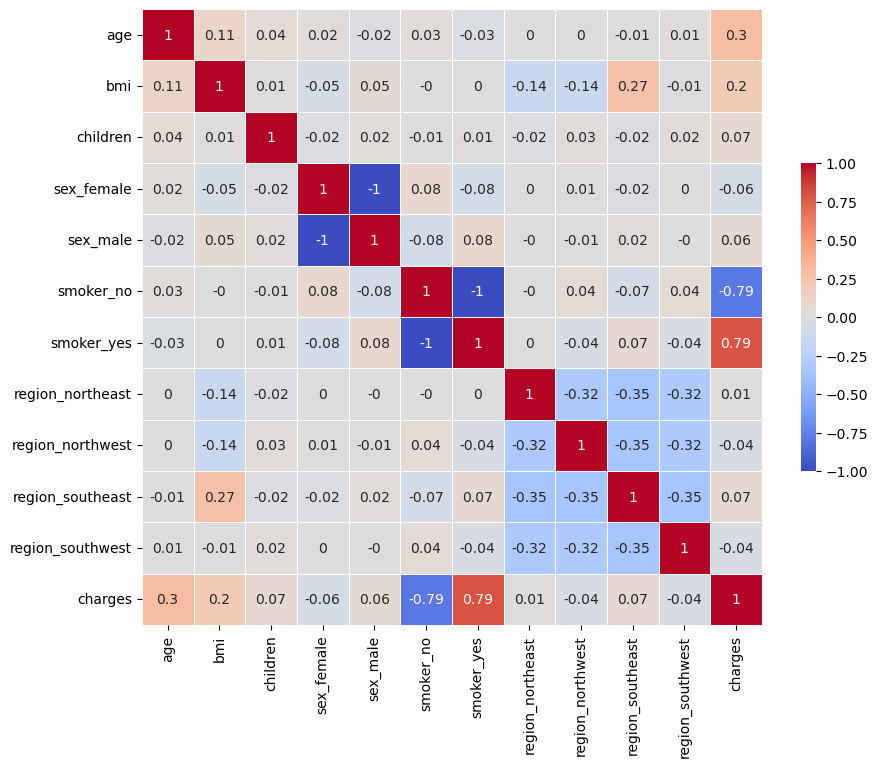

In [7]:
cor = round(data.corr(), 2)
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(cor, cmap='coolwarm', annot=True, vmin=-1, vmax=1, center=0, linewidths=.5, cbar_kws={"shrink": .5})
ax.grid(False)
plt.show()

&emsp;**Analysis:** By looking at the last row of the plot, number of children, sex, and region indicate insignificant relationship with the response variable, medical cost. The most significant pearson coefficients are shown in both the **smoker** dummy variables. One of them will be used to train the model. **Age** and **bmi** will also be considered in the process as they showed some correlation with the response variable. Further visualization will be done to examine and confirm the significance of the linear relationship.

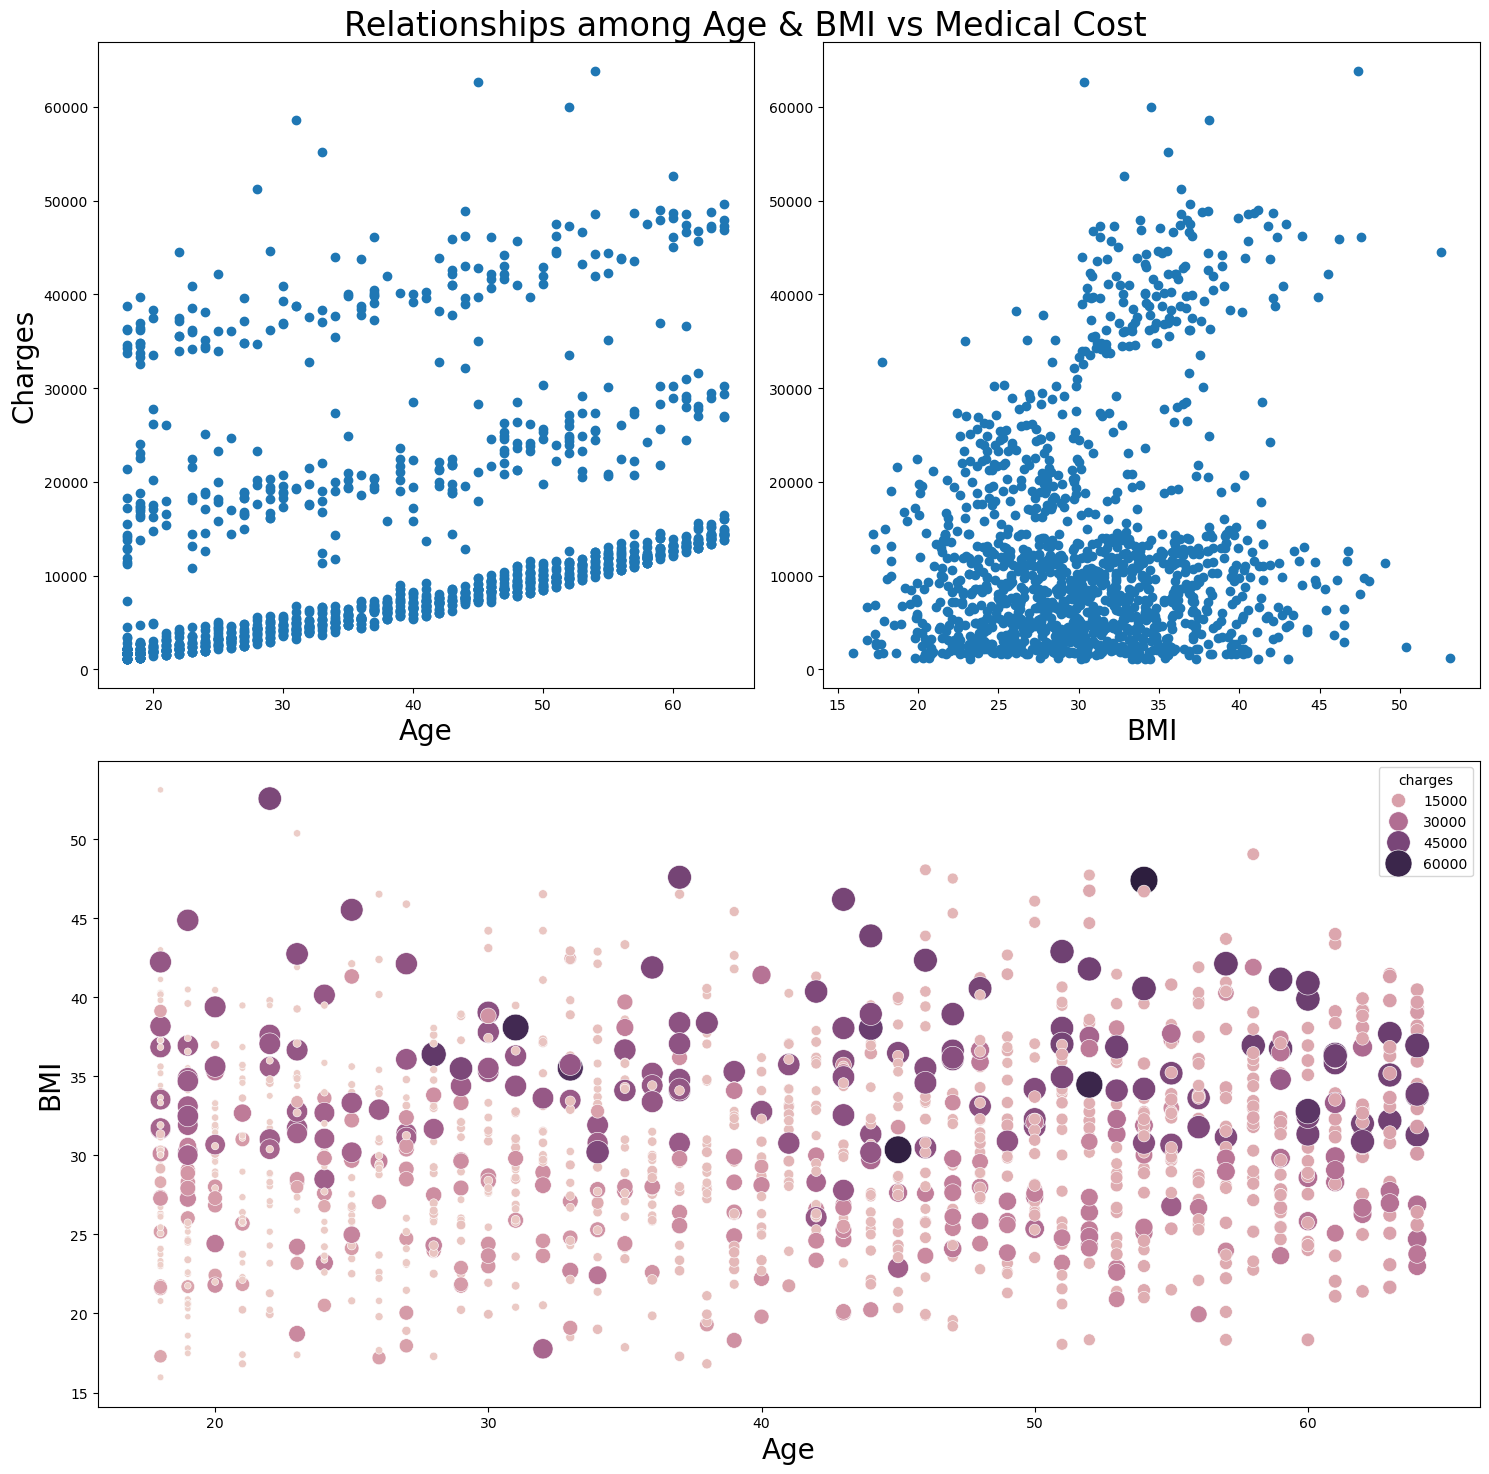

In [8]:
# Scatterplots for age and bmi versus charges
fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(2,2,1)
ax1.scatter(data=data, x='age', y='charges')
ax1.set_xlabel('Age', fontsize=20)
ax1.set_ylabel('Charges', fontsize=20)

ax2 = fig.add_subplot(2,2,2)
ax2.scatter(data=data, x='bmi', y='charges')
ax2.set_xlabel('BMI', fontsize=20)

ax3 = fig.add_subplot(2,1,2)
sns.scatterplot(data=data, x='age', y='bmi', size='charges', sizes=(20,400), hue='charges', ax=ax3)
ax3.legend(title='charges', loc='best')
ax3.set_xlabel('Age', fontsize=20)
ax3.set_ylabel('BMI', fontsize=20)

fig.suptitle("Relationships among Age & BMI vs Medical Cost", fontsize=24)
fig.tight_layout()
plt.show()

&emsp;**Analysis:** Simply looking at the relationships from the scatterplots, **BMI** does not show apparent linear relationship with charges. **Age** shows a positive relationship with charges; however, there is quite a wide variance in charges. Apparently, there are 3 trendlines in the plot. There may be another crucial feature(s) segmenting people into these 3 groups. As a result, before **Age** and **Smoker** are used to train the model, DBSCAN and Gaussian Mixture Model will be used to cluster the people into desirably 3 groups.<a id='charges-age'></a><a id='bmi'></a>

# CLUSTERING: <a id='clustering'></a>
Analyzing the data in the form of clusters using GMM and DBSCAN Techniques

In [9]:
# Scale features for DBSCAN 
scaler = StandardScaler()
scaled = pd.DataFrame(scaler.fit_transform(data[['age','charges']]), columns=[['age','charges']])
# DBSCAN
db = DBSCAN()
clusters_db = db.fit_predict(scaled)
np.unique(clusters_db)

array([-1,  0])

In [10]:
# Gaussian Mixture Modelling 
gm = GaussianMixture(n_components=3)
clusters_gm = gm.fit_predict(data[['age','charges']])
np.unique(clusters_gm)

array([0, 1, 2])

&emsp;**Analysis:** DBSCAN and Gaussian Mixture Model (GMM) clustering algorthms were used. DBSCAN auto discovers the number of clusters based on density whereas GMM is a distance based probabilistic model where covariance structure is taken into account (Baruah 2020). The number of clusters, 3, is chosen for GMM clustering based on the [visualization](#charges-age). DBSCSAN, on the other hand, detected 2 clusters. The relationship between **Age** and **Charges** are displayed again with the labels from the clustering algorithms.

In [11]:
data['db'] = clusters_db + 1
data['gm'] = clusters_gm

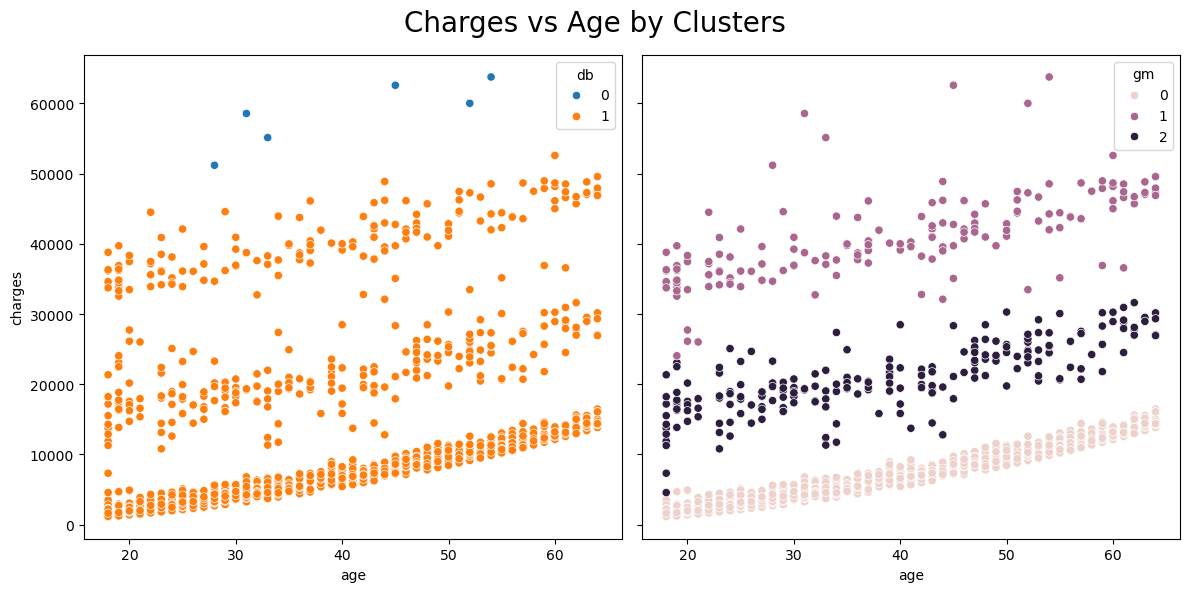

In [12]:
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(1,2,1)
sns.scatterplot(x="age", y="charges", hue="db", data=data, ax=ax1)

ax2 = fig.add_subplot(1,2,2)
sns.scatterplot(x="age", y="charges", hue="gm", data=data, ax=ax2)
ax2.set_ylabel("")
ax2.set_yticklabels([])

fig.suptitle("Charges vs Age by Clusters", fontsize=20)
fig.tight_layout()
plt.show()

&emsp;**Analysis:** **DBSCAN**, in this case, was only able to separate the scattered outliers from the three main trendlines. On the other hand, the **GMM** algorithm managed to label the data points from the trendlines into 3 clusters. Thus, the labels from **GMM** will be used for model training. Before training, the labels are conveted into dummy variables due to their nominal characteristic.

In [13]:
data.drop(columns=['db'], inplace=True)
data = pd.get_dummies(data, columns=['gm'], drop_first=True, dtype=int)
data.head(2)

,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest,charges,gm_1,gm_2
0,19,27.90,0,1,0,0,1,0,0,0,1,16884.9240,0,1
1,18,33.77,1,0,1,1,0,0,0,1,0,1725.5523,0,0


# Model Training<a id='train'></a>

In [14]:
# Predictors and response variable
X = data.drop(columns=['charges'])
y = data['charges']
# Training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=4)

In [15]:
# Fitting training data
# Baseline Model - Linear Regression
lm = LinearRegression()
lm.fit(X_train[['smoker_yes','age','gm_1','gm_2']], y_train)
train_pred = lm.predict(X_train[['smoker_yes','age','gm_1','gm_2']])
print('Intercept =', lm.intercept_)
print('Coefficient =', lm.coef_)
print('Root mean squared error =', mean_squared_error(y_train, train_pred, squared=False))
print('R squared =', r2_score(y_train, train_pred))

Intercept = -3684.874698947435
Coefficient = [ 1515.49514708   273.19288477 32528.34720647 13054.52199559]
Root mean squared error = 2226.0939535946286
R squared = 0.9672804621887083


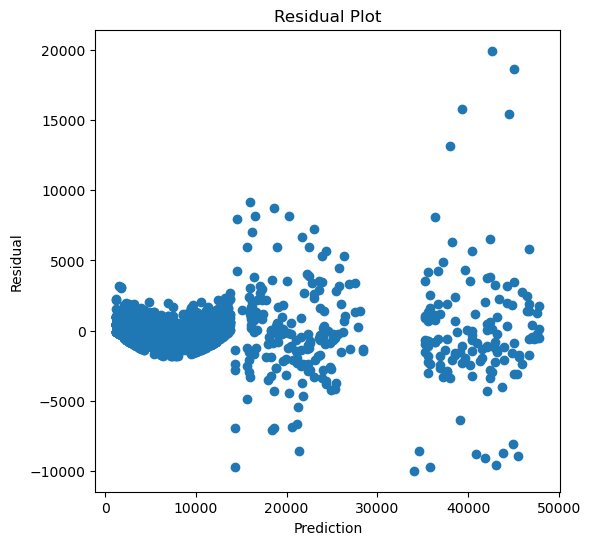

In [16]:
#Residual Plot
residuals = y_train - train_pred
plt.figure(figsize=(6,6))
plt.scatter(train_pred, residuals)
plt.xlabel("Prediction")
plt.ylabel("Residual")
plt.title("Residual Plot")
plt.show()

&emsp;**Analysis:** The residual plot gives a strange distribution of values. The gap may be caused by the strong effect of the categorical feature **Smoker**. The residuals with prediction values lower than 15000 shows a curve which indicates a non-linearity relationship between the medical costs and the predictors. Additionally, the residuals diverges as prediction values increases. This non-uniform variance of residuals may be addressed by additional feature or feature(s) transformation. Despite the residual plot violates the assumptions for a linear regression model, model is validated with unseen test data to review the performance. After that, improvement may be implemented accordingly.

# Model Evaluation & Interpretation<a id='eval-interpret'></a>

Root mean squared error = 1998.46360600815
R squared = 0.9681969938736165


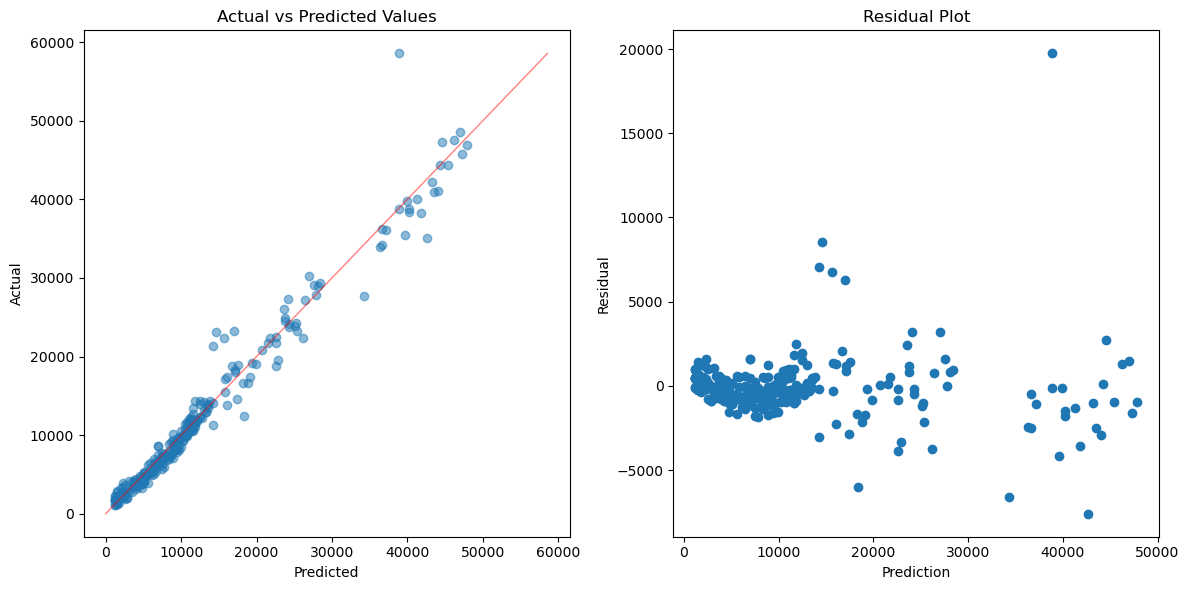

In [17]:
# Evaluate with test data
test_pred = lm.predict(X_test[['smoker_yes','age','gm_1','gm_2']])
print('Root mean squared error =', mean_squared_error(y_test, test_pred, squared=False))
print('R squared =', r2_score(y_test, test_pred))

# Visualize accuracy and residuals
fig, axes = plt.subplots(1,2, figsize=(12,6))
axes[0].scatter(test_pred, y_test, alpha=.5)
axes[0].plot([0,y_test.max()],[0,y_test.max()], lw=1, color='red', alpha=.5)
axes[0].set_ylabel("Actual")
axes[0].set_xlabel("Predicted")
axes[0].set_title("Actual vs Predicted Values")

residuals = y_test - test_pred
axes[1].scatter(test_pred, residuals)
axes[1].set_xlabel("Prediction")
axes[1].set_ylabel("Residual")
axes[1].set_title("Residual Plot")

fig.tight_layout()
plt.show()

&emsp;**Analysis:** The root mean squared error even improved when the prediction is carried out on test data. The coefficient of determination ($R^2$) decreases from .967 to .966 which means the model is not under- or over-fitted.  

&emsp;As shown in the Actual vs Predicted Values plot, the model seems to be able to accurately predict values in the low range of medical cost. This could be explained by sampling error which its sign is also shown and partially explained in the [scatterplot](#charges-age) previously which shows 3 separated trendlines. The bottom trendline is much denser than other two. Although all the trendlines gradually go up with age, the amount of medical cost differs. The potential reason to this could be explained by wealth of the people or their choices of medical expenditure allocation. Private hospital usually charges much more than the public hospitals. The trendlines could be explained by the type of hospital or services the people choose to receive.  

# Reference<a id='reference'></a>
https://www.kaggle.com/datasets/teertha/ushealthinsurancedataset